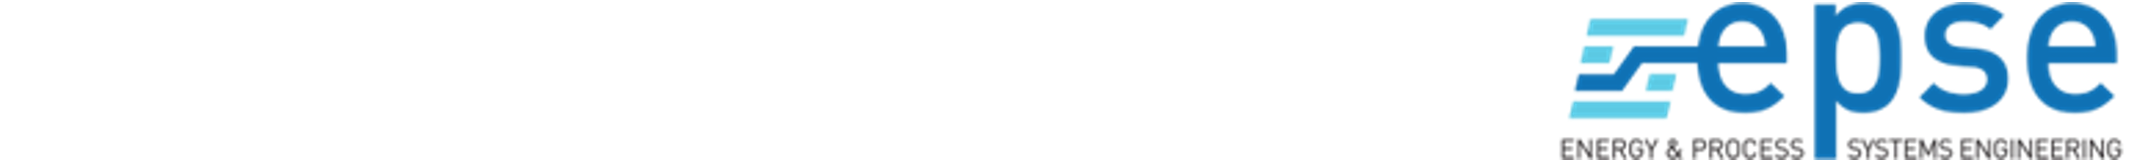

<p style='text-align: right;'> Sustainable Heating and Cooling Technologies </p>
<p style='text-align: right;'> Spring Semester 2025 </p>
<p style='text-align: right;'> Exercise 3 </p>
<p style='text-align: right;'> 05.03.2025 </p>

# <center>  Heat Pump Design - Student Project </center> 

To determine thermodynamic states in the process, the program Fluid_CP.py is used and imported at the head of the program. To calculate the heat pump process states, the heat pump model from exercise 2 is used.
To optimize evaporation and condensation temperatures of the heat pump process regarding the COP, the functions *minimize*  and *NonlinearConstraint* from the *scipy.optimize* library are used. A tutorial on using the *minimize* function is available in the moodle course.


In [1]:
from pylab import *
import Fluid_CP as FCP #calculation of  thermodynamic states
import plotDiag_Th_Ts as Diag #plot Th diagram with heat sink and heat source
from scipy.optimize import  minimize,NonlinearConstraint #optimization
import Compressormodel_SP as CM
import CoolProp.CoolProp as CP

First, we define given parameters.

In [2]:
#refrigerant
delta_T_sh=10. #K #superheating --> assumption
delta_T_sc=5. #K #subcooling --> assumption
fluid="R1234yf"# ---> must be varied 
Eh="CBar"

#source
fluid_so="air"
T_so_in=20. #°C
T_so_out= T_so_in #°C -> parallel flow, same temperature in and out 

#sink
fluid_si="water"
T_si_in=85. #°C
T_si_out=85. #°C -> to be determined for every timestep

#heat exchanger
min_pinch=0.5 #K -> assumption

tube_diameter = 6.38
_D = [35,40,45,50] #possible compressor sizes in mm

In [ ]:
def calc_eta(param_calc):
    eta_is = CM.recip_comp_SP(param_calc,fluid)
    return eta_is

def calc_mdot(param_calc):
    m_dot = CM.recip_comp_SP(param_calc,fluid)
    return m_dot

### Create Heat-pump process


In [17]:
def HP(param):
    
    T_co, T_ev = param

    # Thermodynamic states of the heat pump process
    # State 1*: evaporator: T1 = T_ev and x1 = 1.0 (saturated vapor)
    param_calc = T_ev, T_co, delta_T_sh, None, _D
    eta_is = calc_eta(param_calc)

    # State 1*: saturated vapor at evaporator pressure
    state1_sat = FCP.state(["T", "x"], [T_ev, 1.0], fluid, Eh)

    # State 1: outlet evaporator, superheated vapor if delta_T_sh > 0
    if delta_T_sh > 0.0:
        state1 = FCP.state(["T", "p"], [T_ev + delta_T_sh, state1_sat["p"]], fluid, Eh)
    else:
        state1 = state1_sat

    # State 3*: saturated liquid at condenser outlet temperature
    state3_sat = FCP.state(["T", "x"], [T_co, 0.0], fluid, Eh)

    # State 3: subcooled liquid at condenser outlet
    state3 = FCP.state(["T", "p"], [T_co - delta_T_sc, state3_sat["p"]], fluid, Eh)

    # State 3x: dewpoint at condenser pressure (x = 1)
    state3x = FCP.state(["T", "x"], [T_co, 1.0], fluid, Eh)

    # State 2s: ideal isentropic compression (s2s = s1, p2s = p3)
    state2s = FCP.state(["p", "s"], [state3["p"], state1["s"]], fluid, Eh)

    # h2 from compressor efficiency
    h2 = state1["h"] + (state2s["h"] - state1["h"]) / eta_is

    # State 2: actual compressor outlet
    state2 = FCP.state(["p", "h"], [state3["p"], h2], fluid, Eh)

    # State 4: after expansion valve (isenthalpic), p4 = p1, h4 = h3
    state4 = FCP.state(["p", "h"], [state1["p"], state3["h"]], fluid, Eh)

    return {
        "state1_sat": state1_sat,
        "state1": state1,
        "state2s": state2s,
        "state2": state2,
        "state3_sat": state3_sat,
        "state3": state3,
        "state3x": state3x,
        "state4": state4
    }

In [23]:
print(HP((-5,35))["state1_sat"]["p"])

8.952056819613832


c:\Users\aless\Documents\Personal docs\Studium\Master Energy Science and Technology\2. Semester\Sustainable Heating and Cooling Technologies\SHC_project\Compressormodel_SP.py:41: RuntimeWarning: invalid value encountered in scalar power
  eta_vol = 1. - b0*(p_ratio - 1.)**b1


## Task a) COP function
We define a function that returns the reciprocal value of the coefficient of performance (*COP*). This function is called *calc_COP* and reads the variable parameter *param=[T_co,T_ev]*, a vector of the evaporation temperature *T_co* and the condensation temperature *T_ev*, as input parameters. The optimizer *minimize* requires that all optimization variables are passed in a vector. 

In [44]:
def calc_COP(param): #--> include the COP_rev here...
    T_co,T_ev=param
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)

    states = HP(param)

    state1_sat = states["state1_sat"]
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    state1 = states["state1"]

    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=states["state3_sat"]
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=states["state3"]

    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=states["state2s"]
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=states["state2"]

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=states["state4"]

    #spec. heat released in the condenser
    q_high=state2["h"]-state3["h"] #kJ/kg
    #spec. compressor work
    w_comp=state2["h"]-state1["h"]  #kJ/kg
    #coefficient of performance 

    COP=q_high/w_comp
    #return reciprocal value of COP
    return 1./COP

In [45]:
print(calc_COP((-5,35)))

1.4045430059266448e-05


## Task b) Pinch points
Pinch points are possible in both heat exchangers (condenser and evaporator). A pinch point is defined as the location in heat exchangers where the temperature difference between hot and cold fluid can become a minimum. 
The pinch point can be either at the inlet, outlet, or inside the heat exchanger. The evaporator has its pinch points at in- and outlet for a simple heat pump process. However, the condenser usually has three pinch points: at in- and outlet and at the dew line of the refrigerant. To determine the pinch point, the temperature differences between the hot and the cold stream in the heat exchanger are calculated for these three options. The heat sink/source temperature at the respective locations is calculated using the energy balance (sink/source). 
The location in the evaporator and condenser having the smallest temperature differences is the current pinch point, respectively. The minimum temperature is not called pinch temperature but approach temperature.

The optimization shall be constrained to a minimum approach temperature. As the first step to program constraints, we define functions that calculate the values of the parameters to be constrained. Here: *pinch_con* and *pinch_evap* determine the minimum approach temperatures at all possible positions within the condenser and evaporator. The inputs of these functions have to be the same as for the objective function (*param*).

### Pinch points evaporator (in- or outlet)

In [46]:
def pinch_evap(param):
    T_co,T_ev=param
    
    param_calc = T_ev,T_co, delta_T_sh, None, _D
    eta_is = calc_eta(param_calc)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)
    
    ##### Evaporator outlet
    #The temperature difference at the outlet of the evaporator *delta_T_out_ev* is the difference 
    #between the inlet temperature of the source *T_so_in* and the outlet temperature of the refrigerant *T_1*.
    delta_T_out_ev=T_so_in-state1["T"]
    
    ##### Evaporator inlet
    #The temperature difference at the inlet of the evaporator *delta_T_in_ev* is the difference 
    #between the outlet temperature of the source *T_so_out* and the inlet temperature of the refrigerant *T_4*. 
    delta_T_in_ev=T_so_out-state4["T"]
    
    #return the values at inlet and outlet as a vector
    return [delta_T_in_ev,delta_T_out_ev]

### Pinch points condenser (in- , outlet or dew line refrigerant)

In [47]:
def pinch_con(param):
    T_co,T_ev=param
    
    
    param_calc = T_ev,T_co, delta_T_sh, None, _D
    eta_is = calc_eta(param_calc)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat
    
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2=state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)
    
    ##### Condenser outlet 
    #The temperature difference at the outlet of the condenser *delta_T_out_co* is the difference 
    #between the outlet temperature of the refrigerant *T_3* and the inlet temperature of the sink *T_si_in*.
    delta_T_out_co=state3["T"]-T_si_in

    ##### Condenser inlet
    #The temperature difference at the inlet of the condenser *delta_T_in_co* is the difference 
    #between the inlet temperature of the refrigerant *T_2* and the outlet temperature of the sink *T_si_out*.
    delta_T_in_co=state2["T"]-T_si_out
    
    ##### Dew line condenser (refrigerant)
    #The temperature difference at the inside of the condenser *delta_T_inside_co* is the difference between the condenser
    #temperature *T_con* and the temperature of the heat sink at the dew line of the refrigerant *T_si_inside*.
    
    #enthalpy of the refrigerant at the inlet/outlet of the condenser
    h_out_co=state3["h"]
    h_in_co=state2["h"]
    #enthalpy of saturated vapor at T_co and p_co: h_sat_Tco
    h_sat_Tco=FCP.state(["T","x"],[T_co,1.0],fluid,Eh)["h"]

    #Enthalpies of heat sink 
    h_si_in=FCP.state(["T","p"],[T_si_in,1.0],fluid_si,Eh)["h"]
    h_si_out=FCP.state(["T","p"],[T_si_out,1.0],fluid_si,Eh)["h"]

    #State of the heat sink at the point the refrigerant passes the dew line
    h_si_inside=h_si_out-(h_si_out-h_si_in)/(state2["h"]-state3["h"])*(state2["h"]-h_sat_Tco)
    T_si_inside=FCP.state(["p","h"],[1.0,h_si_inside],fluid_si,Eh)["T"]
    #temperature difference
    delta_T_inside_co=T_co-T_si_inside
    
    #return the values at inlet, outlet, and dew line as a vector
    return [delta_T_in_co,delta_T_out_co,delta_T_inside_co]


## Condenser Length

### R_L_evap and R_L_sh

In [48]:
#thermal resistance times tube length for convective heat transfer
def calc_RL_conv(h_transfer,d_tube_inner):
    R_L_conv=1./(h_transfer*pi*d_tube_inner) #mK/W
    return R_L_conv

#thermal resistance times tube length for conductive heat transfer
def calc_RL_cond(lambda_w,d_w,d_out,d_i):
    R_L_cond= d_w/(lambda_w*((d_out-d_i)/(log(d_out/d_i)))*pi) #mK/W
    return R_L_cond


In [49]:
h_refVapLiq = 2000 #W/m^2/K
h_refVap = 200 #W/m^2/K
h_refLiq = 1000 #W/m^2/K
lambda_steel = 25 #W/m/K
d_i = 0.00635 #m
d_out = 0.0055 #m
h_water = 1000 #W/m^2/K
d_w = 0.00635 - 0.0055 #m
max_length_condenser = 3 #m

#convective heat transfer inner tube wall
R_L_h_refVap = calc_RL_conv(h_refVap,d_i)
#conductive heat transfer through wall
R_L_lambda_w=calc_RL_cond(lambda_steel,d_w,d_out,d_i)
#convective heat transfer outer tube wall
R_L_h_water=calc_RL_conv(h_water,d_out)

R_L_sh=R_L_h_refVap+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during condensation in superheated state=",round(R_L_sh,4),"mK/W")

thermal resistance per meter during condensation in superheated state= 0.3103 mK/W


In [50]:
#convective heat transfer inner tube wall
R_L_h_reflat=calc_RL_conv(h_refVapLiq,d_i)

R_L_lat=R_L_h_reflat+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during latent=",round(R_L_lat,4),"mK/W")

thermal resistance per meter during latent= 0.0848 mK/W


In [51]:
#convective heat transfer inner tube wall
R_L_h_refLiq=calc_RL_conv(h_refLiq,d_i)

R_L_sc=R_L_h_refLiq+R_L_lambda_w+R_L_h_water
print("thermal resistance per meter during subcooling=",round(R_L_sc,4),"mK/W")

thermal resistance per meter during subcooling= 0.1098 mK/W


In [52]:
def calc_spec_length(param):
    T_co,T_ev =param

    param_calc = T_ev,T_co, delta_T_sh, None, _D
    eta_is = calc_eta(param_calc)
    #thermodynamic states of the heat pump process
    #state 1*: evaporator: T1=T_ev and x1=1.0 (saturated vapor)
    state1_sat=FCP.state(["T","x"],[T_ev,1.0],fluid,Eh)
    #state 1: outlet evaporator: T1=T_ev+delta_T_sh and p1=p1_sat
    if delta_T_sh>0.:
        state1=FCP.state(["T","p"],[T_ev+delta_T_sh,state1_sat["p"]],fluid,Eh)
    else:
        state1=state1_sat

    print(T_co)
    #state 3*: outlet condenser: T3=T_co and x3=0.0 (boiling liquid)
    state3_sat=FCP.state(["T","x"],[T_co,0.0],fluid,Eh)
    
    #state 3: outlet condenser: T3=T_co-delta_T_sc and p3=p3_stat
    state3=FCP.state(["T","p"],[T_co-delta_T_sc,state3_sat["p"]],fluid,Eh)
    #state 3x: condenser dewline -> x=1
    state3x = FCP.state(['T','x'],[T_co,1],fluid,Eh)
    
    #state 2s: isentropic compressor: p2s=p_co=p3 and s2s=s1 
    state2s=FCP.state(["p","s"],[state3["p"],state1["s"]],fluid,Eh)
    #enthalpy h2 is calulated using the compressor efficiency eta_is
    h2 = state1["h"]+(state2s["h"]-state1["h"])/eta_is
    #state 2: outlet compressor: p2=p_co=p3 and h2
    state2=FCP.state(["p","h"],[state3["p"],h2],fluid,Eh)

    #state 4: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
    state4=FCP.state(["p","h"],[state1["p"],state3["h"]],fluid,Eh)

    m_dot = calc_mdot(param_calc)
    #heat flow evaporator
    Q_con_sh = m_dot*(h2-state3x['h']) #kW
    Q_con_lat =m_dot*(state3x["h"]-state3_sat["h"]) #kW
    Q_con_sc = m_dot*(state3_sat['h'] - state3['h'])
    print("Heat for condensing superheat=",round(Q_con_sh,2),"kW")
    print("Heat for condensing latent=",round(Q_con_lat,2),"kW")
    print("Heat for condensing subcooling=",round(Q_con_sc,2),"kW")
    print("Heat in= ",round(Q_con_sh+Q_con_lat+Q_con_sc,2),"kW")
    
    T3sat = state3_sat['T']
    T3x = state3x['T']
    T2 = state2['T']
    #temperarture of air=constant 
    T_water_worst_case = T_si_in #can be adjusted, depends on the heatpump design and controlling 
    
    
    #logarithmic mean temperature difference during condensing, all steps 
    #deltaT_m_sc=(((T3sat - delta_T_sc)- T_water_worst_case) - (T3sat - T_water_worst_case))/(log(((T3sat - delta_T_sc) - T_water_worst_case )/(T3sat - T_water_worst_case)))
    #eltaT_m_sh=((T3x - T_water_worst_case) - (T2 - T_water_worst_case))/(log((T3x - T_water_worst_case)/(T2 - T_water_worst_case))) 
    
    deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
    deltaT_m_sh=((T2 - T_water_worst_case) - (T3x - T_water_worst_case))/(log((T2 - T_water_worst_case)/(T3x - T_water_worst_case))) 
    
    L_con_sc = -Q_con_sc*1000.*R_L_sh/(deltaT_m_sc)/1000
    L_con_lat = -Q_con_lat*1000.*R_L_lat/(T3sat - T_water_worst_case)/1000
    L_con_sh = -Q_con_sh*1000.*R_L_sc/(deltaT_m_sh)/1000
    print("Tube length for condensing superheating= ",round(L_con_sh,2),"m")
    print("Tube length for condensing latent= ",round(L_con_lat,2),"m")
    print("Tube length for condensing subcooling= ",round(L_con_sc,2),"m")
    L_t=L_con_sc+L_con_lat+L_con_sh
    print("Total length of the evaporator tube=",round(L_t,2),"m")
    return L_t

## Task c) Optimization
As we want to optimize the heat pump process regarding the COP, *calc_COP* is the objective function (function to be optimized). Since optimizers always minimize a function the return value of the function *calc_COP* is the reciprocal of COP (1/COP). 

### Bounds
We use *bounds* to define boundaries for varying the condenser and evaporator temperature during the optimization.<br>
Syntax: *bounds=[(param[0]_min,param[0]_max),(param[1]_min, param[1]_max)]*. \
To facilitate and accelerate the optimization, we can define clever limits of the temperature ranges.
- The condensation temperature cannot go below the inlet temperature of the heat sink
- As we know that decreasing evaporation temperatures decrease the COP, we can assume that T_ev will not go below -15°C 
- As we know that increasing condensation temperatures decrease the COP, we can assume that T_co will not go above 50°C. Option: A hard criterion is that the condensation temperature cannot be larger than the critical temperature in a subcritical process.
- The evaporation temperature can never go above the source inlet temperature

In [53]:
#Syntax: bounds=[(T_co_min, T_co_max), (T_ev_min, T_ev_max)]
#Define appropriate bounds
bounds=[(T_so_in,np.inf),(-np.inf,T_si_in)] #(T_co_min, T_co_max), (T_ev_min, T_ev_max)

### NonlinearConstraints
We use the function *NonlinearConstraints* to communicate our constraints to the optimization routine. Here, we refer to our functions which calculate the approach temperatures and define minimum and maximum values for all return values of these functions. <br>

In [54]:
#For a function funct with three return values, nonlinear constaints are defined as follows:
#Syntax: NC1=NonlinearConstraint(func, [min_1,min_2,min_3],[max_1,max_2, max_3])
#Define the nonlinear constaints for the approach temperatures: NC1, NC2
NC1=NonlinearConstraint(pinch_evap, [min_pinch,min_pinch],[np.inf,np.inf])
NC2=NonlinearConstraint(pinch_con, [min_pinch,min_pinch,min_pinch],[np.inf,np.inf,np.inf])
NC3=NonlinearConstraint(calc_spec_length, 0,40)
#All constraints can be combined into a tuple
#Syntax:  NCs=(NC1, NC2,....)
NCs=[NC1,NC2,NC3]

### Starting the optimization
We optimize the condenser and evaporator temperatures using the function *minimize*. As we want to give boundaries and nonlinear constraints, we choose the method *SLSQP* (Sequential Least Squares Programming). The optimizer needs a starting point for the optimization. The starting point must have the same structure than the optimization vector (param). Hint: It is important that the initial guess meets all constraints and the bounds

In [55]:
#Define an appropriate initial guess (starting point).
T_co_start=90. #°C
T_ev_start=9. #°C
#Use minimize to optimize the COP
Opti=minimize(calc_COP,x0=[T_co_start,T_ev_start],method='SLSQP',bounds=bounds,constraints=NCs)
#Check if the optimization terminated successfull and print the COP
print("Success optimization=",Opti.success)
COP=1./calc_COP(Opti.x)
print("optimized COP = ",round(COP,2))
#Print the optimized evaporator and condenser temperature: T_ev_op, T_co_op
T_ev_op=Opti.x[1]
T_co_op=Opti.x[0]
print("optimized condensation temperature= ",round(T_co_op,2),"°C")
print("optimized evaporation temperature= ",round(T_ev_op,2),"°C")

90.0
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -inf m
Total length of the evaporator tube= -inf m
90.00000134110451
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -8.4 m
Total length of the evaporator tube= -9.18 m
90.0
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -inf m
Total length of the evaporator tube= -inf m
90.0
Hea

C:\Users\aless\AppData\Local\Temp\ipykernel_20356\528593277.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  deltaT_m_sc=((T3sat - T_water_worst_case) - ((T3sat - delta_T_sc)- T_water_worst_case))/(log((T3sat - T_water_worst_case)/((T3sat - delta_T_sc) - T_water_worst_case )))
C:\Users\aless\AppData\Local\Temp\ipykernel_20356\528593277.py:58: RuntimeWarning: divide by zero encountered in scalar divide
  L_con_sc = -Q_con_sc*1000.*R_L_sh/(deltaT_m_sc)/1000


90.0
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -inf m
Total length of the evaporator tube= -inf m
90.0
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -inf m
Total length of the evaporator tube= -inf m
90.00000001490116
Heat for condensing superheat= 26.25 kW
Heat for condensing latent= 31.99 kW
Heat for condensing subcooling= 8.94 kW
Heat in=  67.19 kW
Tube length for condensing superheating=  -0.24 m
Tube length for condensing latent=  -0.54 m
Tube length for condensing subcooling=  -10.9 m
Total length of the evaporator tube= -11.68 m
90.0
H

### Post-processing 
We calculate the thermodynamic states of the optimized heat pump process.

In [14]:
#thermodynamic states of the heat pump process as a function of the optimal evaporation and condensation temperatures
#state1_sat_op: evaporator: T1=T_ev_op and x1=1.0 (saturated vapor)
state1_sat_op=FCP.state(["T","x"],[T_ev_op,1.0],fluid,Eh)
#state1_op: outlet evaporator: T1=T_ev_op+delta_T_sh and p1=p1_sat
if delta_T_sh>0.:
    state1_op=FCP.state(["T","p"],[T_ev_op+delta_T_sh,state1_sat_op["p"]],fluid,Eh)
else:
    state1_op=state1_sat_op

#state3_sat_op: outlet condenser: T3=T_co_op and x3=0.0 (boiling liquid)
state3_sat_op=FCP.state(["T","x"],[T_co_op,0.0],fluid,Eh)
#state3_op: outlet condenser: T3=T_co_op-delta_T_sc and p3=p3_stat
state3_op=FCP.state(["T","p"],[T_co_op-delta_T_sc,state3_sat_op["p"]],fluid,Eh)

params = T_ev_op ,T_co_op, delta_T_sh,_, _D
eta_is = calc_eta(params)

#state2s_op: isentropic compressor: p2s=p_co=p3 and s2s=s1 
state2s_op=FCP.state(["p","s"],[state3_op["p"],state1_op["s"]],fluid,Eh)
#enthalpy h2 is calulated using the compressor efficiency eta_is
h2_op=state1_op["h"]+(state2s_op["h"]-state1_op["h"])/eta_is
#state2_op: outlet compressor: p2=p_co=p3 and h2
state2_op=FCP.state(["p","h"],[state3_op["p"],h2_op],fluid,Eh)
#state4_op: outlet throttle: p4=p_ev=p1 and h4=h3 (isenthalpic throttle)
state4_op=FCP.state(["p","h"],[state1_op["p"],state3_op["h"]],fluid,Eh)

Further, we create a Th diagram using the *Th* function from *plotDiag_Th_Ts.py*.

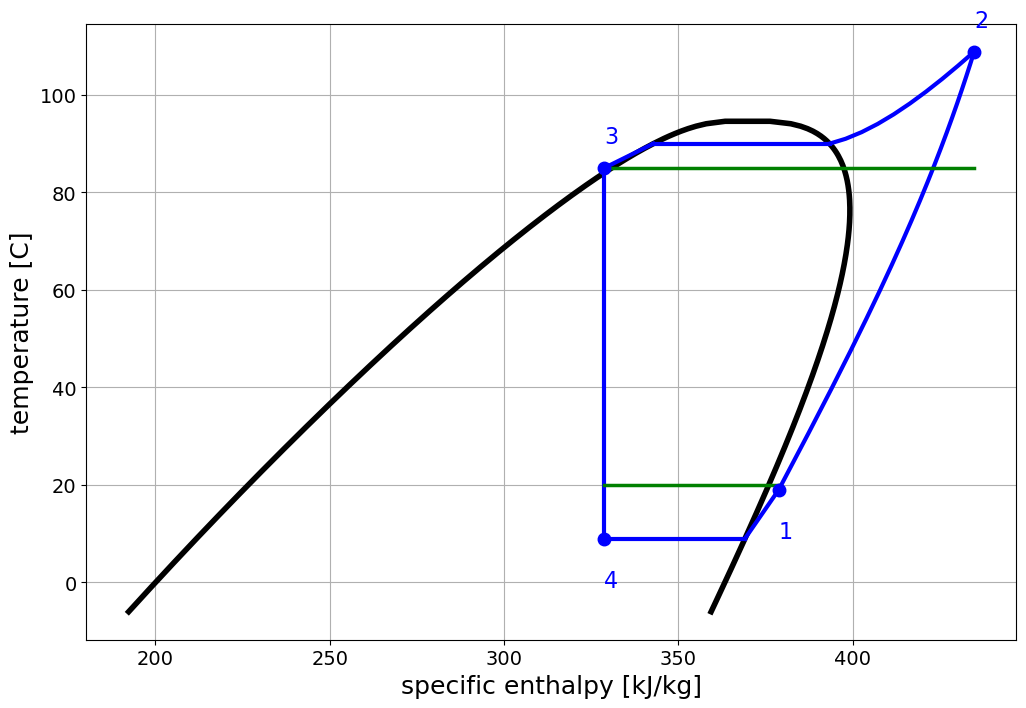

In [15]:
Diag.Th(state1_op,state2_op,state3_op,state4_op,[T_si_in,T_si_out],[T_so_in,T_so_out],fluid,Eh)

The pinch points in the evaporator and the condenser are calculated with the functions *pinch_evap* and *pinch_con*.

In [ ]:
#evaporator
delta_T_pinch_ev=pinch_evap([T_co_op,T_ev_op])
print("Pinch evaporator (optimized): delta_T_pinch_v=",round(min(delta_T_pinch_ev[0],delta_T_pinch_ev[1]),4),"K")
print(delta_T_pinch_ev)
#condenser
delta_T_pinch_co=pinch_con([T_co_op,T_ev_op])
print(delta_T_pinch_co)
print("Pinch condenser (optimized): delta_T_pinch_c=",round(min(delta_T_pinch_co[0],delta_T_pinch_co[1],delta_T_pinch_co[2]),4),"K")

Pinch evaporator (optimized): delta_T_pinch_v= 0.5 K
[5.500000000007049, 0.5]
[23.593914828817958, 0.5678076876551472, 0.500009748802313]
Pinch condenser (optimized): delta_T_pinch_c= 0.5 K


## Discussion
The determined pinch points of the heat pump process can be seen in the Th diagram. In the evaporator, the pinch point is at the outlet of the evaporator. In the condenser, the pinch point is at the dew line. 

The COP of the optimized heat pump process is 4.36. The optimized condenser and evaporator temperatures are: *T_co* =35.57°C and *T_ev* =-0.5°C. Choosing the optimal evaporation and condenser temperature is crucial for the performance of heat pumps.